In [662]:
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

ESTABLISHING PARAMETERS

In [663]:
# Define the cryptocurrency and date range for data retrieval using yfinance
crypto = 'BTC-USD'
#Setting a 10 year window, chosen arbitrarily
start_date = '2023-08-01'
#end date is set to the current date
end_date = dt.datetime.now().strftime('%Y-%m-%d')

In [664]:
#Downloading daily Bitcoin pricing data from Yahoo Finance
BTC_pricing = yf.download(crypto, start=start_date, end=end_date, interval='1d')

BTC_pricing

C:\Users\ryley\AppData\Local\Temp\ipykernel_21144\3185590587.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  BTC_pricing = yf.download(crypto, start=start_date, end=end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2023-08-01,29675.732422,29675.732422,28657.023438,29230.873047,18272392391
2023-08-02,29151.958984,29987.998047,28946.509766,29704.146484,19212655598
2023-08-03,29178.679688,29375.707031,28959.488281,29161.812500,12780357746
2023-08-04,29074.091797,29302.078125,28885.335938,29174.382812,12036639988
2023-08-05,29042.126953,29102.464844,28957.796875,29075.388672,6598366353
...,...,...,...,...,...
2025-08-13,123344.062500,123682.453125,118939.632812,120168.976562,90904808795
2025-08-14,118359.578125,124457.117188,117254.882812,123339.398438,104055627395


In [665]:
#Cleaning data, removing all columns aside from close price and date, setting as copy to avoid copy warning down the line
BTC_pricing.reset_index(inplace=True)
BTC_pricing = BTC_pricing[['Date',  'Close']].copy()
#Converting date column to datetime format for easier manipulation
BTC_pricing['Date'] = pd.to_datetime(BTC_pricing['Date'])

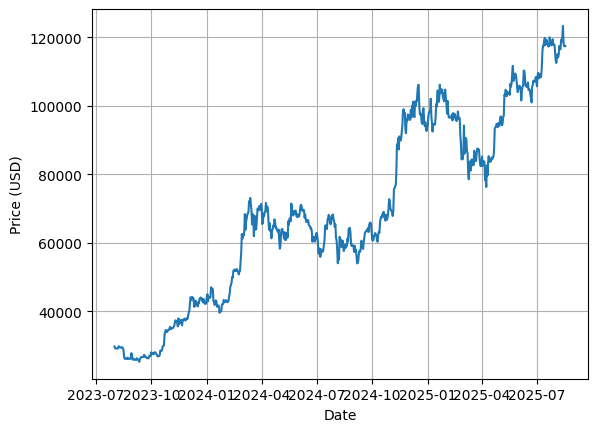

In [666]:
#visualizing the Bitcoin pricing data for last 10 years
plt.plot(BTC_pricing['Date'],BTC_pricing['Close'])
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()


In [667]:
#Setting Close price lag features for 1, 2, and 3 days to use as ML features

#Loops through range of 1 to 3, creating new column with a lag shift of 1, 2, and 3 days respectively
for i in range(1,4):
    BTC_pricing[f'{i}_Days_Close_Price_Lag'] = BTC_pricing['Close'].shift(i)

#Dropping rows with NaN values after lagging
BTC_pricing.dropna(inplace=True)  
BTC_pricing

Price,Date,Close,1_Days_Close_Price_Lag,2_Days_Close_Price_Lag,3_Days_Close_Price_Lag
Ticker,,BTC-USD,,,
3,2023-08-04,29074.091797,29178.679688,29151.958984,29675.732422
4,2023-08-05,29042.126953,29074.091797,29178.679688,29151.958984
5,2023-08-06,29041.855469,29042.126953,29074.091797,29178.679688
6,2023-08-07,29180.578125,29041.855469,29042.126953,29074.091797
7,2023-08-08,29765.492188,29180.578125,29041.855469,29042.126953
...,...,...,...,...,...
743,2025-08-13,123344.062500,120172.906250,118731.445312,119306.757812
744,2025-08-14,118359.578125,123344.062500,120172.906250,118731.445312
745,2025-08-15,117398.351562,118359.578125,123344.062500,120172.906250


In [668]:
#Split date, close, and lagged close prices into separate arrays for input into model

#Set dates array as date column from BTC pricing dataframe, convert to datetime format
dates = BTC_pricing['Date'].dt.date

#Set lagged close prices (day lags 1 to 3) as separate df, converting to float values
lag_close = BTC_pricing[['1_Days_Close_Price_Lag', '2_Days_Close_Price_Lag', '3_Days_Close_Price_Lag']].values.astype(float)
#Reshape lag_close into array...lag_close.shape[0] is the number of rows (days), lag_close.shape[1] is the number of features (lags 1, 2, 3), 1 is the number of features
lag_close = lag_close.reshape((lag_close.shape[0], lag_close.shape[1], 1))

#Set current close prices as a separate array, converting to float values
current_close = BTC_pricing['Close'].values.astype(float)


In [669]:
#Scaling lag close prices and close prices to range between 0 and 1 for better model performance using MinMaxScaler from sklearn
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Flatten lags and current close into 2D arrays for scaling, then sklearn scales between 0 and 1
lag_close_scaled = scaler_X.fit_transform(lag_close.reshape(-1,1)).reshape(lag_close.shape)
current_close_scaled = scaler_y.fit_transform(current_close.reshape(-1,1))

In [670]:
#Separating train/test data into 70/30 split

#Setting train split as 70% of the total number of rows from dataset (BTC pricing days)
train_split = int(len(dates) * 0.7)

#Slicing date, lagged close prices, and current close prices into separate training arrays (with initial 70% of the data)
train_dates = dates[:train_split]
train_lag_close = lag_close_scaled[:train_split]
train_current_close = current_close_scaled[:train_split]

#Setting validation split as 20% of the total number of rows from dataset (BTC pricing days)
val_split = int(len(dates) * 0.2)

#Slicing date, lagged close prices, and current close prices into separate validation arrays (with next 20% of the data)
val_dates = dates[train_split:train_split + val_split]
val_lag_close = lag_close_scaled[train_split:train_split + val_split]
val_current_close = current_close_scaled[train_split:train_split + val_split]

#Setting test split as 10% of the total number of rows from dataset (BTC pricing days)
test_split = int(len(dates) * 0.1)

#Slicing date, lagged close prices, and current close prices into separate test arrays (with last 10% of the data)
test_dates = dates[train_split + val_split:]
test_lag_close = lag_close_scaled[train_split + val_split:]
test_current_close = current_close_scaled[train_split + val_split:]



In [671]:
#Testing tensorflow model (works best for timeseries data?)

#Setting NN model
model = Sequential([
	layers.Input((3,1)), #input shape of lagged close prices (3 days of lag prices) input as 1 feature (1 column)
	layers.LSTM(64), #64 neurons (common choice, played around with different values) for learning layer
    layers.Dense(32, activation='relu'), #layer takes 64 neurons output and applies ReLU non-linearity to model (to learn complex relationships)
    layers.Dense(32, activation='relu'), #same as above, increases model ability to learn complex relationships
    layers.Dense(1)  #Output layer for predicting the next close price (singular float value output)
])

In [672]:
#Compiling above model. Adam Optimizer to update weights within neurons during training (most common choice for optimizer that I found online, learning rate of 0.001 most common choice but found more accurate in this case at 0.0001) 
#Loss function set to evaluate and minimized mean squared error between prediction and actual BTC close price during training 
#Outputs mean absolute error metric for model performance evaluation, no confuring square error
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [673]:
#training model with training data, validating with validation data, trial with 200 epochs (to check for overfitting as well)). 200 epochs overkill, changed to 100 epochs
fitted_model = model.fit(train_lag_close, train_current_close, epochs=100, validation_data=(val_lag_close, val_current_close),verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1414 - mae: 0.3159 - val_loss: 0.4758 - val_mae: 0.6841
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1314 - mae: 0.3028 - val_loss: 0.4512 - val_mae: 0.6661
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1239 - mae: 0.2929 - val_loss: 0.4312 - val_mae: 0.6510
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1168 - mae: 0.2833 - val_loss: 0.4108 - val_mae: 0.6353
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1095 - mae: 0.2734 - val_loss: 0.3891 - val_mae: 0.6182
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1019 - mae: 0.2631 - val_loss: 0.3665 - val_mae: 0.5997
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0938 - mae: 0.2519 - val_loss: 0.3419 - val_mae: 0.5790
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0855 - mae: 0.2397 - val_loss: 0.3152 - val_mae: 0.5558
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0

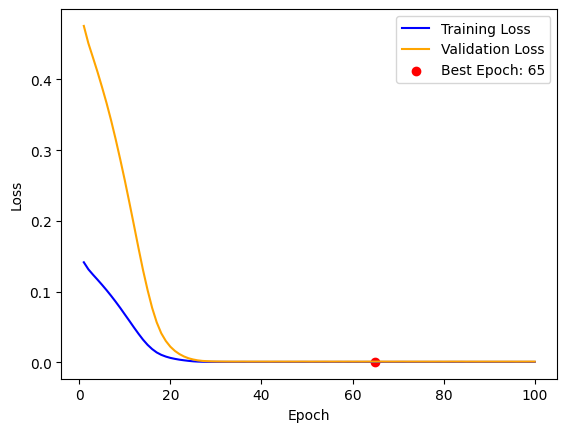

range(1, 101)

In [674]:

#Checking which epoch of training was best to check for overkill on number of epochs/ overfitting
#Pulling training and validation loss from fitted model (above) history
train_loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']

#set number of epochs from above model parameters starting at 1 (not index 0)
epochs = range(1, len(train_loss)+1)

# Find the epoch with minimum validation loss (epoch with lowest validation loss = best epoch), any epoch beyond this point is probably overfitting (val loss increasing)
best_epoch_0 = np.argmin(val_loss)
best_epoch = best_epoch_0 +1  # Adding 1 to convert from index to "best" epoch number
best_val_loss = val_loss[best_epoch_0] #Best validation loss starting at index 0

#plotting training and validation loss to visualize model performance over epochs
#Plotting training loss vs number of epochs on x axis
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
#Plotting validation loss vs number of epochs on x axis
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')

# Highlighting the best epoch with minimum validation loss (starting at index 1)
plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Epoch: {best_epoch}')

#Setting labels and legend 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
epochs

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Text(0.5, 1.0, 'Training Data: Predicted vs Actual Close Prices')

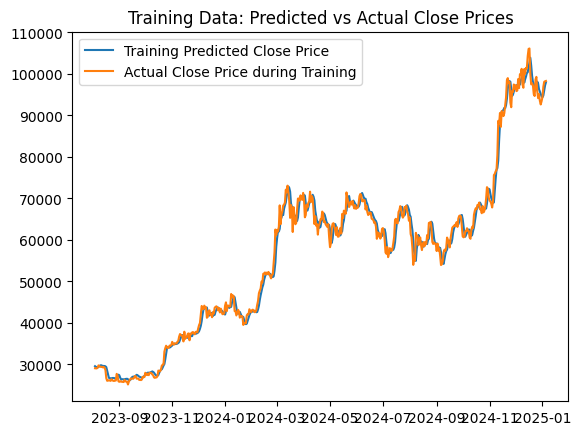

In [675]:
#Converted scaled training data back to USD to plot 
train_predictions_scaled = model.predict(train_lag_close)
train_predictions = scaler_y.inverse_transform(train_predictions_scaled).flatten()
train_current_close = scaler_y.inverse_transform(train_current_close).flatten()

#Plotting training close price predictions vs actual close prices during training dates
#Matches almost perfectly, model is performing well on training data
plt.plot(train_dates, train_predictions)
plt.plot(train_dates, current_close[:train_split])
plt.legend(['Training Predicted Close Price', 'Actual Close Price during Training'])
plt.title('Training Data: Predicted vs Actual Close Prices')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Text(0.5, 1.0, 'Validation Data: Predicted vs Actual Close Prices')

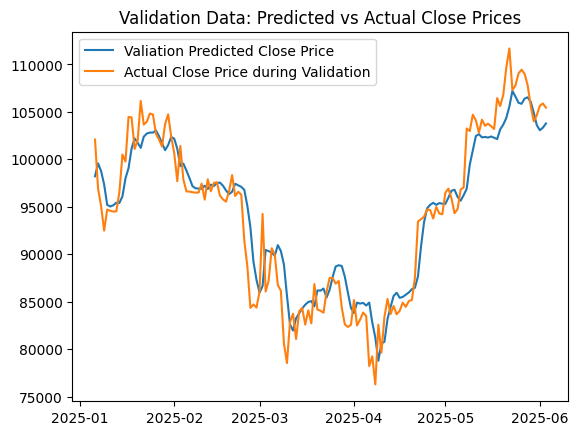

In [676]:

#Converted scaled validation data back to USD to plot 
val_predictions_scaled = model.predict(val_lag_close)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled).flatten()
val_current_close = scaler_y.inverse_transform(val_current_close).flatten()

#Plotting validation close price predictions vs actual close prices during validation dates
#Matches almost perfectly, model is performing well on validation data, slight mispredictions
plt.plot(val_dates, val_predictions)
plt.plot(val_dates, val_current_close)
plt.legend(['Valiation Predicted Close Price', 'Actual Close Price during Validation'])
plt.title('Validation Data: Predicted vs Actual Close Prices')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Text(0.5, 1.0, 'Test Data: Predicted vs Actual Close Prices')

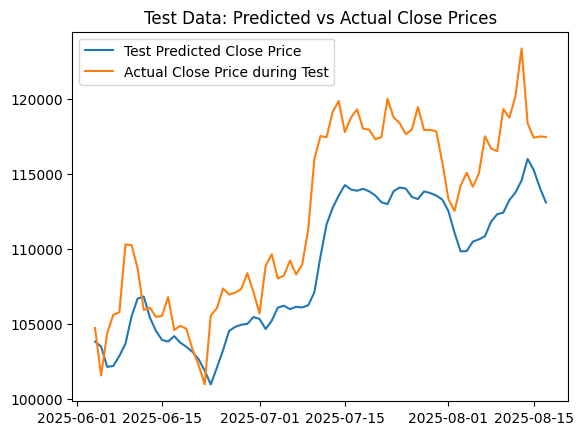

In [677]:

#Converted scaled test data back to USD to plot
test_predictions_scaled = model.predict(test_lag_close)
test_predictions = scaler_y.inverse_transform(test_predictions_scaled).flatten()
test_current_close = scaler_y.inverse_transform(test_current_close).flatten()

#Plotting test close price predictions vs actual close prices during test dates
#Mispredictions, clearly model is underpredicting during test phase
plt.plot(test_dates, test_predictions)
plt.plot(test_dates, test_current_close)
plt.legend(['Test Predicted Close Price', 'Actual Close Price during Test'])
plt.title('Test Data: Predicted vs Actual Close Prices')

In [678]:
#Predicting the next day BTC close price

#Taking last 3 days lag prices, reshaping to fit model (1 prediction, 3 lag inputs, 1 feature)
last_3_days_lag = lag_close_scaled[-1].reshape((1,3,1))

#Using model to predict next day close price using this lag data above
next_day_prediction_scaled = model.predict(last_3_days_lag)
#Converting this prediction back to USD from scaled data
next_day_prediction = scaler_y.inverse_transform(next_day_prediction_scaled).flatten()[0]

#Nicely formatted output
print(f"next day prediction : ${next_day_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
next day prediction : $113090.5234375
